In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import random_split
from torch.utils.data import SubsetRandomSampler
from random import sample

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import glob
from PIL import Image as I

import pandas as pd

import os

import numpy as np

import timeit

# Data Processing

Loading Train Data

In [2]:
#Train size: 22424
#Validation size: 5606


dd_train = dset.ImageFolder('imgs/train', transform=T.Compose([T.Resize((224,224)), T.ToTensor()]))
# dd_train = dset.ImageFolder('/content/drive/My Drive/imgs/train', transform=T.ToTensor())
train_set, val_set = random_split(dd_train,[16818,5606])

load_train = DataLoader(train_set, batch_size=32)
load_val = DataLoader(val_set, batch_size=32)


#train_set.dataset[i] returns a tuple (tensor object, correct label)

Loading Test Data

In [3]:
'''
CustomImageFolder to also return the image file name in the tensor
Useful if we choose to split the test data due to its large size
'''

class customImageFolder(dset.ImageFolder):
    def __getitem__(self, index):
        return (super(customImageFolder, self).__getitem__(index)[0], self.imgs[index][0].split('\\')[-1])

test_set = customImageFolder('imgs/test', transform=T.Compose([T.Resize((224,224)), T.ToTensor()]))

load_test = DataLoader(test_set, batch_size = 32)

#test_set[i] returns a tuple (tensor object, dummy label, image file name)
print(test_set[0])


(tensor([[[0.1725, 0.1725, 0.1725,  ..., 0.9137, 0.9294, 0.8157],
         [0.1725, 0.1725, 0.1725,  ..., 0.9333, 0.9490, 0.9569],
         [0.1725, 0.1725, 0.1725,  ..., 0.9412, 0.9569, 0.9686],
         ...,
         [0.0353, 0.0353, 0.0353,  ..., 0.0784, 0.0902, 0.1294],
         [0.0353, 0.0353, 0.0353,  ..., 0.0784, 0.0902, 0.1255],
         [0.0353, 0.0353, 0.0353,  ..., 0.0667, 0.0863, 0.1059]],

        [[0.2353, 0.2353, 0.2353,  ..., 0.9843, 0.9765, 0.8549],
         [0.2353, 0.2353, 0.2353,  ..., 0.9922, 0.9922, 0.9882],
         [0.2353, 0.2353, 0.2353,  ..., 0.9922, 0.9922, 0.9882],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.0549, 0.0706, 0.1059],
         [0.0392, 0.0392, 0.0392,  ..., 0.0667, 0.0784, 0.1137],
         [0.0392, 0.0392, 0.0392,  ..., 0.0667, 0.0863, 0.1020]],

        [[0.1922, 0.1922, 0.1922,  ..., 0.9412, 0.9373, 0.8118],
         [0.1922, 0.1922, 0.1922,  ..., 0.9647, 0.9647, 0.9608],
         [0.1922, 0.1922, 0.1922,  ..., 0.9882, 0.9843, 0

Visualizing Data

Label: 6
(224, 224)


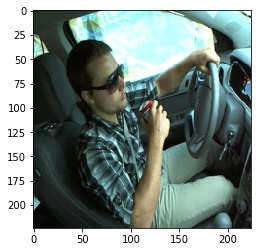

In [4]:
'''
Testing to visualize the image
'''

pilTrans = T.ToPILImage()
pilImg = pilTrans(train_set[0][0])
imgplot = plt.imshow(pilImg)
print("Label:", train_set[0][1])
print(pilImg.size)

# Model

In [5]:
torch.cuda.is_available()

True

In [6]:
'''
Creating Model
'''
import torchvision.models as models

# class VGG16(nn.Module):

#     def __init__(self):
#         super(VGG16, self).__init__()
#         self.conv1 = nn.Conv2d(3, 64, 3)
#         self.conv2 = nn.Conv2d(64, 64, 3)

#         self.conv3 = nn.Conv2d(64, 128, 3)
#         self.conv4 = nn.Conv2d(128, 128, 3)

#         self.conv5 = nn.Conv2d(128, 256, 3)
#         self.conv6 = nn.Conv2d(256, 256, 3)
#         self.conv7 = nn.Conv2d(256, 256, 3)

#         self.conv8 = nn.Conv2d(256, 512, 3)
#         self.conv9 = nn.Conv2d(512, 512, 3)
#         self.conv10 = nn.Conv2d(512, 512, 3)

#         self.conv11 = nn.Conv2d(512, 512, 3)
#         self.conv12 = nn.Conv2d(512, 512, 3)
#         self.conv13 = nn.Conv2d(512, 512, 3)

#         self.fc1 = nn.Linear(1605632, 4096)
#         self.fc2 = nn.Linear(4096, 4096)
#         self.fc3 = nn.Linear(4096, 1000)

#     def forward(self, x, batch_size):
#         x = F.relu(self.conv1(x))
#         x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
#         x = F.relu(self.conv3(x))
#         x = F.max_pool2d(F.relu(self.conv4(x)), (2, 2))
#         x = F.relu(self.conv5(x))
#         x = F.relu(self.conv6(x))
#         x = F.max_pool2d(F.relu(self.conv7(x)), (2, 2))
#         x = F.relu(self.conv8(x))
#         x = F.relu(self.conv9(x))
#         x = F.max_pool2d(F.relu(self.conv10(x)), (2, 2))
#         x = F.relu(self.conv11(x))
#         x = F.relu(self.conv12(x))
#         x = F.max_pool2d(F.relu(self.conv13(x)), (2, 2))
#         x = x.view(batch_size, -1)
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

num_classes = 10
net = models.resnet18()
net.fc = nn.Linear(512, num_classes)
gpu_net = net.to('cuda')

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(gpu_net.parameters(), lr=0.001, momentum=0.9, nesterov=True)

# Code snippet from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
for epoch in range(2):  # loop over the dataset multiple times

    running_train_loss = 0.0
    for i, data in enumerate(load_train):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = gpu_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        

        # print statistics
        running_train_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] Train loss: %.3f' %
                  (epoch + 1, i + 1, running_train_loss / 50))
            running_train_loss = 0.0

    running_val_loss = 0.0
    for i, data in enumerate(load_val):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = gpu_net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_val_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print('[%d, %5d] Validation loss: %.3f' %
                  (epoch + 1, i + 1, running_val_loss / 50))
            running_val_loss = 0.0

print('Finished Training and Validation')
torch.save(gpu_net.state_dict(), 'training.pt')

[1,    50] Train loss: 2.322
[1,   100] Train loss: 2.304
[1,   150] Train loss: 2.276
[1,   200] Train loss: 2.231
[1,   250] Train loss: 2.191
[1,   300] Train loss: 2.091
[1,   350] Train loss: 2.004
[1,   400] Train loss: 1.868
[1,   450] Train loss: 1.693
[1,   500] Train loss: 1.517
[1,    50] Validation loss: 1.179
[1,   100] Validation loss: 0.956
[1,   150] Validation loss: 0.784
[2,    50] Train loss: 0.594
[2,   100] Train loss: 0.480
[2,   150] Train loss: 0.384
[2,   200] Train loss: 0.307
[2,   250] Train loss: 0.288
[2,   300] Train loss: 0.209
[2,   350] Train loss: 0.174
[2,   400] Train loss: 0.156
[2,   450] Train loss: 0.151
[2,   500] Train loss: 0.148
[2,    50] Validation loss: 0.142
[2,   100] Validation loss: 0.102
[2,   150] Validation loss: 0.096
Finished Training and Validation


In [7]:
gpu_net.load_state_dict(torch.load('training.pt'))
correct = 0
total = 0
with torch.no_grad():
    for data in load_train:
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = gpu_net(inputs)
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

train_accuracy = round(correct/total, 3)
print("Train accuracy:", train_accuracy)

correct = 0
total = 0
with torch.no_grad():
    for data in load_val:
        inputs, labels = data
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        outputs = gpu_net(inputs)
        predicted = torch.argmax(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

val_accuracy = round(correct/total, 3)
print("Validation accuracy:", val_accuracy)

Train accuracy: 0.993
Validation accuracy: 0.997


In [8]:
softmax = nn.Softmax(dim=1)
csv_data = []
with torch.no_grad():
    for data in load_test:
        inputs, filenames = data
        inputs = inputs.to('cuda')
        outputs = gpu_net(inputs)
        outputs = softmax(outputs)
        outputs = outputs.tolist()
        for filename, output in zip(filenames, outputs):
            row = [filename]
            row.extend(output)
            csv_data.append(row)
    df = pd.DataFrame(data=csv_data, dtype='object',
                 columns=['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'])
    df = df.sort_values(by=['img'])
    df.to_csv('distracted_driver_submission.csv', index=False, line_terminator='\n')